# Kaggle Leaf Classification Challenge


In [162]:
ls

6_1_EXE_Kaggle_Leaf_Challenge.ipynb  Submission.ipynb  pickles/
NN.ipynb                             __pycache__/      sample_submission.csv
NN_1.ipynb                           data_utils.py     test.csv
Preprocessing.ipynb                  images/           train.csv
README.md                            my_process.md


In [163]:
cd ~/Documents/dl/LeafClassification

/zhome/68/a/154632/Documents/dl/LeafClassification


In [164]:
%matplotlib inline
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
import time

from IPython.display import clear_output
from skimage.io import imread
from skimage.transform import resize

import data_utils

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

import pickle

In [165]:
use_cuda = torch.cuda.is_available()
if use_cuda:
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x


def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

The code will run on GPU.


# Load pickle

In [166]:
# Load the data from a pickle file
with open('pickles/data.pickle', 'rb') as f:
    data = pickle.load(f)

# Batch Generator

## Exercise 6
6.1) Explain shortly why the size of batches is important. You should comment on how the size of batches affect the memory, training speed, and the estimates of the gradients.
Choose a reasonable batch size the `batch_size = ?` parameter below, and note your choice.

In [167]:
batch_size = 32
NUM_CLASSES = 99
dummy_batch_gen = data_utils.batch_generator(data, batch_size=batch_size, num_classes=NUM_CLASSES, num_iterations=5e3, seed=42)
train_batch = next(dummy_batch_gen.gen_train())
valid_batch, i = next(dummy_batch_gen.gen_valid())
test_batch, i = next(dummy_batch_gen.gen_test())

print("TRAIN")
print("\timages,", train_batch['images'].shape)
print("\tmargins,", train_batch['margins'].shape)
print("\tshapes,", train_batch['shapes'].shape)
print("\ttextures,", train_batch['textures'].shape)
print("\tts,", train_batch['ts'].shape)
print()
print("VALID")
print("\timages,", valid_batch['images'].shape)
print("\tmargins,", valid_batch['margins'].shape)
print("\tshapes,", valid_batch['shapes'].shape)
print("\ttextures,", valid_batch['textures'].shape)
print("\tts,", valid_batch['ts'].shape)
print()
print("TEST")
print("\timages,", test_batch['images'].shape)
print("\tmargins,", test_batch['margins'].shape)
print("\tshapes,", test_batch['shapes'].shape)
print("\ttextures,", test_batch['textures'].shape)
print("\tids,", len(test_batch['ids']))

TRAIN
	images, (32, 128, 128, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

VALID
	images, (32, 128, 128, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ts, (32, 99)

TEST
	images, (32, 128, 128, 1)
	margins, (32, 64)
	shapes, (32, 64)
	textures, (32, 64)
	ids, 32


# Build the model

## Exercise 7
7.1)  Now you must define the network architecture. It is always a good idea to start simple. We recommend you to start with a mix of a convolutional layer (maybe followed by max pooling layer), a recurrent layer, and a linear output layer such that we use all the features.  

When you build the model you should be aware of the dimensions of the input and output for your different layers. The function`permute` and `view` will be very useful to rearrange your dimensions.

In [168]:
class SelectItem(nn.Module):
    def __init__(self, item_index):
        super(SelectItem, self).__init__()
        self._name = 'selectitem'
        self.item_index = item_index

    def forward(self, inputs):
        return inputs[self.item_index]

In [169]:
IMAGE_SHAPE = (128, 128, 1)
num_species = 99
NUM_FEATURES = 64

In [177]:
height, width, channels = IMAGE_SHAPE

conv_out_channels = 8 # <-- Filters in your convolutional layer
kernel_size = (3, 3)       # <-- Kernel size
conv_stride = 2       # <-- Stride
conv_pad    = 1       # <-- Padding
 
# Keep track of features to output layer
features_cat_size = 1024 # <-- Number of features concatenated before output layer

rnn_input_size = 64 # must be the same as the x_shape channels
    
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.convolutional = nn.Sequential(
            nn.Conv2d(in_channels=channels,
                    out_channels=conv_out_channels,
                    kernel_size=kernel_size,
                    stride=conv_stride,
                    padding=conv_pad),
            nn.ReLU()
        )

        self.fc1 = nn.Sequential(
            nn.Linear(in_features=32768,
                    out_features=768,
                    bias=False)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(in_features=128,
                    out_features=128,
                    bias=False)
        )

        # Exercise: Add a recurrent unit like and RNN or GRU
        # >> YOUR CODE HERE <<
        self.recurrent = nn.Sequential(
            nn.GRU(input_size=rnn_input_size, # The number of expected features in the input x
                    hidden_size=128, # The number of features in the hidden state h
                    num_layers=2), # Number of recurrent layers
            SelectItem(0)
        )

        self.l_out = nn.Sequential(
            nn.Linear(in_features=features_cat_size,
                        out_features=NUM_CLASSES,
                        bias=False)
        )
        
        
    def forward(self, x_img, x_margin, x_shape, x_texture):
        features = []
        out = {}

        # Change layer order in images
        x_img = x_img.permute(0, 3, 1, 2)
        
        ## Convolutional layer ##
        # - Change dimensions to fit the convolutional layer 
        # - Apply Conv2d
        # - Use an activation function
        # - Change dimensions s.t. the features can be used in the final FFNN output layer
        
        # >> YOUR CODE HERE <<
        ## 1st way, distort image
        # print("Convolutional...")
        # print(x_img.shape)
        x_img = self.convolutional(x_img)
        # print(x_img.shape)
        x_img = x_img.reshape(x_img.size(0), -1)
        # print(x_img.shape)
        features_img = self.fc1(x_img)
        # print(features_img.shape)

        # Append features to the list "features"
        features.append(features_img)
        
        ## Use concatenated leaf features for FFNN ##
        # print("\nFeed Forward...")
        # print(x_margin.shape, x_texture.shape)
        x = torch.cat((x_margin, x_texture), dim=1)  # if you want to use features as feature vectors
        # print(x.shape)
        x = self.fc2(x)
        features_vector = x
        # print(features_vector.shape)
        
        ## Use concatenated leaf features for RNN ##
        # - Chage dimensions to fit GRU
        # - Apply GRU
        # - Change dimensions s.t. the features can be used in the final FFNN output layer

        # >> YOUR CODE HERE <<
        # print("\nRecurrent...")
        # print(x_shape.shape)
        features_rnn = self.recurrent(x_shape)
        features.append(features_rnn)
        # print(features_rnn.shape)
        
        # Append features to the list "features"
        features.append(features_rnn)
        
        ## Output layer where all features are in use ##
        # print("\Features...")
        features_final = torch.cat(features, dim=1)
        # print(features_final.shape)
        
        # print("\nOutput...")
        out['out'] = self.l_out(features_final)
        # print(out['out'].shape) 
        # print(out)
        return out

net = Net()
if use_cuda:
    net.cuda()
print(net)

Net(
  (convolutional): Sequential(
    (0): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
  )
  (fc1): Sequential(
    (0): Linear(in_features=32768, out_features=768, bias=False)
  )
  (fc2): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=False)
  )
  (recurrent): Sequential(
    (0): GRU(64, 128, num_layers=2)
    (1): SelectItem()
  )
  (l_out): Sequential(
    (0): Linear(in_features=1024, out_features=99, bias=False)
  )
)


# Build the cost function

## Exercise 8
8.1) Since this is a classification task we will use the cross-entropy loss. Define the cross-entropy loss as the loss function in the code below.

In [171]:
LEARNING_RATE = 0.001
criterion = nn.CrossEntropyLoss()          # <-- Your code here.   

# weight_decay is equal to L2 regularization
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

def accuracy(ys, ts):
    predictions = torch.max(ys, 1)[1]
    correct_prediction = torch.eq(predictions, ts)
    return torch.mean(correct_prediction.float())

# Test network

## Debugging 
The following cell might cause you some errors - try these suggestions before you try anyting else.

* **Your kernel keeps dying** on the line below it is most likely because you run out of memory.
The two most likely solutions are 
 1. reduce the image size further
 1. change your network architecture such that it uses less resources

* **`RuntimeError: size mismatch, m1: [??? x ???], m2: [??? x ???]`** 
 1. `features_cat_size` must match the actual output of the network i.e. the second dimension in `m1`.

* **Training is very slow**. This is most likely caused by the images. 
 1. Try and reduce the size of the images further, or reduce the dimensions of the network using either pooling or strides.


In [172]:
from PIL import Image, ImageOps

def pad2square(img):
    img_shape = img.shape
    r = img_shape[0]
    c = img_shape[1]
    new_side = np.max([r,c])
    padding = ((new_side - c)//2, (new_side - r)//2, int(np.ceil((new_side - c)/2)), int(np.ceil((new_side - r)/2)))
    img_as_img = Image.fromarray(img)
    new_img = ImageOps.expand(img_as_img, padding)
    return np.array(new_img)

In [173]:
_img_shape = tuple([batch_size] + list(IMAGE_SHAPE))
_feature_shape = (batch_size, NUM_FEATURES)

def randnorm(size):
    return np.random.normal(0, 1, size).astype('float32')

# dummy data
_x_image = get_variable(Variable(torch.from_numpy(randnorm(_img_shape))))
_x_margin = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_shape = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))
_x_texture = get_variable(Variable(torch.from_numpy(randnorm(_feature_shape))))

# test the forward pass
print(f"Image shape: {_x_image.shape}")
print(f"Image margin: {_x_margin.shape}")
print(f"Image texture: {_x_texture.shape}")
print(f"Image shape: {_x_shape.shape}\n")
output = net(x_img=_x_image, x_margin=_x_margin, x_shape=_x_shape, x_texture=_x_texture)

Image shape: torch.Size([32, 128, 128, 1])
Image margin: torch.Size([32, 64])
Image texture: torch.Size([32, 64])
Image shape: torch.Size([32, 64])

Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])


# Train

In [174]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
print(input, target, output)
output.backward()

tensor([[-0.2165,  0.7096, -0.4357,  0.3004, -0.6467],
        [-0.5025,  1.1859,  0.2120, -1.3320,  0.5469],
        [ 0.1603,  0.3967, -0.0412,  0.9080,  0.4451]], requires_grad=True) tensor([1, 0, 4]) tensor(1.6746, grad_fn=<NllLossBackward0>)


In [175]:
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
print(input, target, output)
output.backward()

tensor([[ 4.5108e-01,  8.7210e-04,  1.9373e+00,  3.6243e-01, -3.4590e-01],
        [-2.1348e-04, -7.2369e-01,  4.6639e-01,  8.3915e-01,  7.6662e-01],
        [-1.9753e+00,  4.3631e-02, -9.7462e-01, -2.4884e-02, -2.0956e-01]],
       requires_grad=True) tensor([[0.2739, 0.0621, 0.1061, 0.3166, 0.2413],
        [0.0421, 0.0382, 0.1345, 0.1478, 0.6374],
        [0.2628, 0.0976, 0.4624, 0.0829, 0.0943]]) tensor(1.8880, grad_fn=<DivBackward1>)


Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([3, 1, 128, 128])
torch.Size([3, 8, 64, 64])
torch.Size([3, 32768])
torch.Size([3, 768])
Valid, it: 0 loss: 4.60 accs: 0.00

Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])


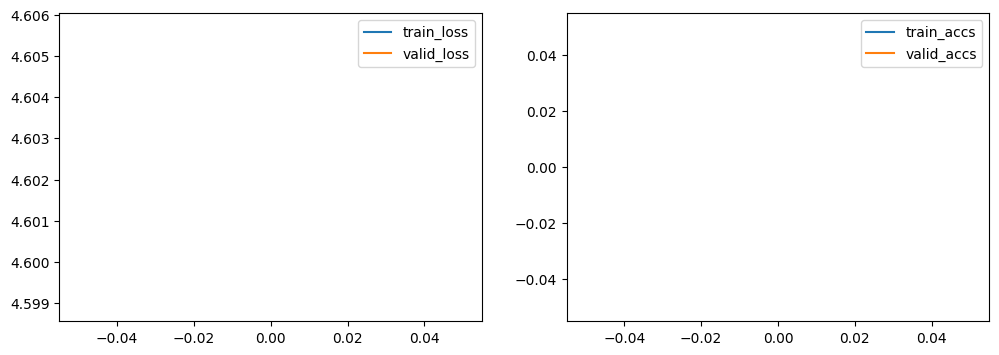

Train, it: 0 loss: 4.61 accs: 0.00
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768

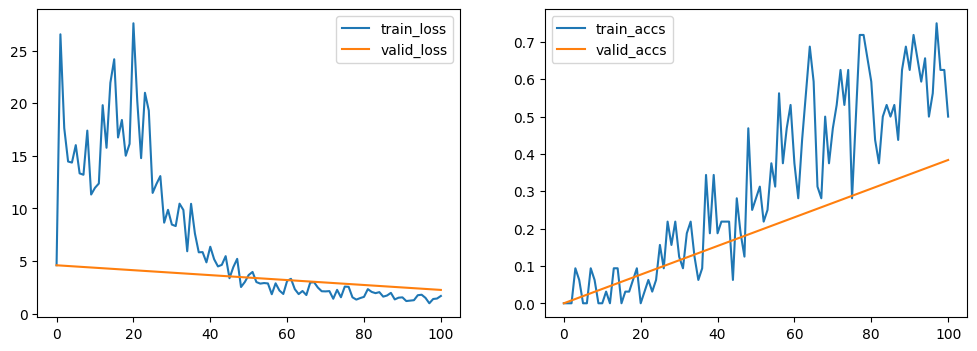

Train, it: 100 loss: 1.68 accs: 0.50
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 7

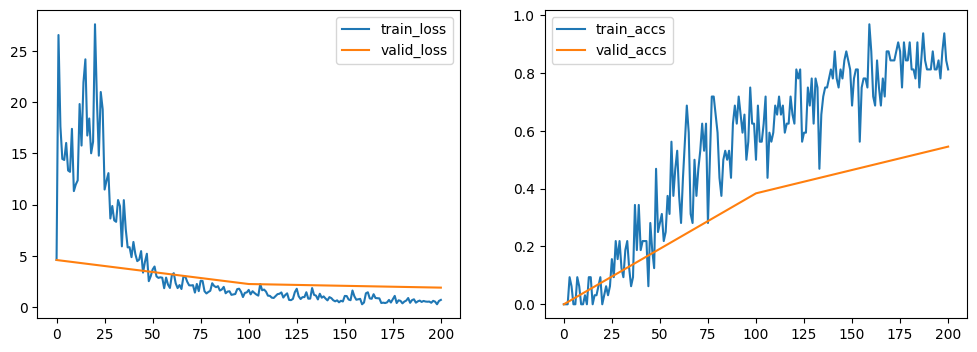

Train, it: 200 loss: 0.71 accs: 0.81
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 7

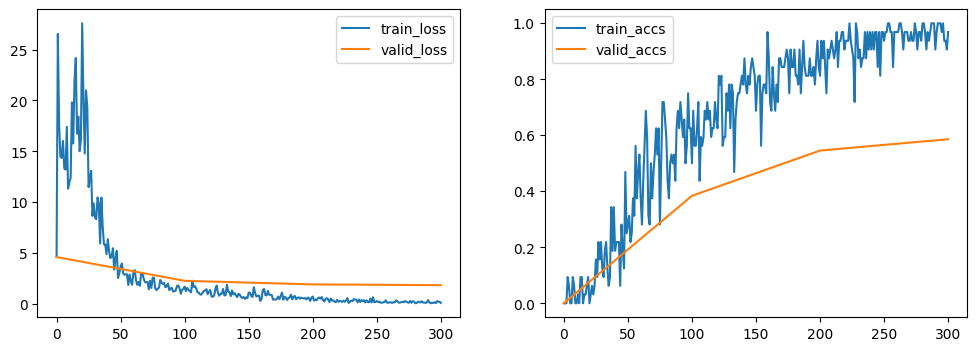

Train, it: 300 loss: 0.09 accs: 0.97
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 768])
Convolutional...
torch.Size([32, 1, 128, 128])
torch.Size([32, 8, 64, 64])
torch.Size([32, 32768])
torch.Size([32, 7

KeyboardInterrupt: 

In [176]:
# Setup settings for training 
VALIDATION_SIZE = 0.1 # 0.1 is ~ 100 samples for validation
max_iter = 1000
log_every = 100
eval_every = 100

# Function to get label
def get_labels(batch):
    return get_variable(Variable(torch.from_numpy(batch['ts']).long()))

# Function to get input
def get_input(batch):
    return {
        'x_img': get_variable(Variable(torch.from_numpy(batch['images']))),
        'x_margin': get_variable(Variable(torch.from_numpy(batch['margins']))),
        'x_shape': get_variable(Variable(torch.from_numpy(batch['shapes']))),
        'x_texture': get_variable(Variable(torch.from_numpy(batch['textures'])))
    }

# Initialize lists for training and validation
train_iter = []
train_loss, train_accs = [], []
valid_iter = []
valid_loss, valid_accs = [], []

# Generate batches
batch_gen = data_utils.batch_generator(data,
                                       batch_size=batch_size,
                                       num_classes=NUM_CLASSES,
                                       num_iterations=max_iter,
                                       seed=42,
                                       val_size=VALIDATION_SIZE)

# Train network
net.train()
for i, batch_train in enumerate(batch_gen.gen_train()):
    # print(_['x_img'].shape, _['x_margin'].shape, _['x_texture'].shape, _['x_shape'].shape)
    if i % eval_every == 0:
        
        # Do the validaiton
        net.eval()
        val_losses, val_accs, val_lengths = 0, 0, 0
        for batch_valid, num in batch_gen.gen_valid():
            output = net(**get_input(batch_valid))
            labels_argmax = torch.max(get_labels(batch_valid), 1)[1]
            # print(output['out'])
            # print(labels_argmax)
            val_losses += criterion(output['out'], labels_argmax) * num
            val_accs += accuracy(output['out'], labels_argmax) * num
            val_lengths += num

        # Divide by the total accumulated batch sizes
        val_losses /= val_lengths
        val_accs /= val_lengths
        valid_loss.append(get_numpy(val_losses))
        valid_accs.append(get_numpy(val_accs))
        valid_iter.append(i)
        print("Valid, it: {} loss: {:.2f} accs: {:.2f}\n".format(i, valid_loss[-1], valid_accs[-1]))
        net.train()
    
    # Train network
    output = net(**get_input(batch_train))
    labels_argmax = torch.max(get_labels(batch_train), 1)[1]
    batch_loss = criterion(output['out'], labels_argmax)
    
    train_iter.append(i)
    train_loss.append(float(get_numpy(batch_loss)))
    train_accs.append(float(get_numpy(accuracy(output['out'], labels_argmax))))
    
    optimizer.zero_grad()
    batch_loss.backward()
    optimizer.step()
    
    # Log i figure
    if i % log_every == 0:
        fig = plt.figure(figsize=(12,4))
        plt.subplot(1, 2, 1)
        plt.plot(train_iter, train_loss, label='train_loss')
        plt.plot(valid_iter, valid_loss, label='valid_loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(train_iter, train_accs, label='train_accs')
        plt.plot(valid_iter, valid_accs, label='valid_accs')
        plt.legend()
        plt.show()
        # clear_output(wait=True)
        print("Train, it: {} loss: {:.2f} accs: {:.2f}".format(i, train_loss[-1], train_accs[-1]))
        
    if max_iter < i:
        break